# Had to develop this blocks in another environment.
Please, uncomment the first import in the next block and delete the second block

In [ ]:
#from ipynb.fs.defs.functions import train_test, classification_reporting
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold


from keras.layers import Dense, Dropout, InputLayer
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf

import pandas as pd
import numpy as np


import tensorflow.keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from skopt import gp_minimize

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

In [ ]:
# Delete this, if needed

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize


# Define train/test dataset splitting, scaling implemented
def train_test(dataset, scaling = False):
    X = dataset.iloc[:,:dataset.shape[1]-1]
    y = dataset.iloc[:,-1]

    if scaling == True:
        X_columns = X.columns.to_list()
        X = pd.DataFrame(normalize(X, axis=0), columns=X_columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=0.2,
        stratify=dataset.iloc[:,-1],
        random_state=42)

    return X_train, X_test, y_train, y_test

# Define the classification report. "macro avg" for precision, recall and f1 will be used as a benchmark
def classification_reporting(tuning, model, y_test, y_pred, X_train):
    report = classification_report(y_test, y_pred, output_dict = True)
    print('{} {} performance using {} features:\n'.format(tuning, model, X_train.shape[1]),
          report['macro avg'])
    print('Accuracy score:', accuracy_score(y_test, y_pred))

In [ ]:
# Split the dataset with 16 feature
dataset = pd.read_csv('/content/drive/MyDrive/dataset.csv').iloc[:,1:]
X_train_full, X_test_full, y_train_full, y_test_full = train_test(dataset, scaling = True)

y_train_full = pd.get_dummies(y_train_full)
y_test_full = pd.get_dummies(y_test_full)

In [ ]:
# Define the model
def model():
  model = Sequential()
  
  # Dense layer, with 32 neurons, ReLu as benchmark
  model.add(Dense(32, input_dim=16, activation='relu'))

  # Turn off the 20% of neurons to avoid overfitting
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))

  # Final dense layer with 5 neurons, one for each label, softmax will output the probabilities of an item to belong to each class
  model.add(Dense(5, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = model()

# Fit the model with epochs = nobs * 3 and batch size = 32 (rules of thumb)
model.fit(X_train_full, y_train_full, epochs = 48, batch_size = 32, verbose = 0)

In [ ]:
# Predict
y_pred = model.predict(X_test_full)

# One-hot encode the probabilities, so that the output is a 0/1 matrix. The class for an observation will be the index of the columns which has the highest probabilities among other columns
y_pred_matrix = pd.DataFrame(np.eye(5)[np.argmax(y_pred, axis = 1)])

classification_reporting('Naive', 'NN', y_test_full, y_pred_matrix, X_train_full)

63/63 [==============================] - 0s 1ms/step
Naive NN performance using 16 features:
 {'precision': 0.7389467638491835, 'recall': 0.72472963880006, 'f1-score': 0.7271623258916967, 'support': 2000}
Accuracy score: 0.725


In [ ]:
accuracy = accuracy_score(y_test_full, y_pred.round())
print('Accuracy of predictions on the test set:', accuracy)

Accuracy of predictions on the test set: 0.6385


# Hyperparameter Tuning - Bayesian Optimization
## WIP

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [ ]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [ ]:
def nn_cl_bo(neurons, activation, optimizer, learning_rate,  batch_size, epochs ):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
                 
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)

    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=16, activation=activation))
        nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(5, activation='softmax'))
        nn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn

    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)

    score = cross_val_score(nn, X_train_full, y_train_full, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score  

In [ ]:
# Set paramaters
params_nn ={
    'neurons': (10, 100),
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=111)
nn_bo.maximize(init_points=2, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------
50/50 [==============================] - 0s 1ms/step
| 1         | nan       | 5.51      | 335.3     | 54.88     | 0.7716    | 36.58     | 1.044     |
50/50 [==============================] - 0s 2ms/step
| 2         | nan       | 0.2023    | 536.2     | 39.09     | 0.3443    | 99.16     | 1.664     |


ValueError: ignored

# Hyperparameter Tuning 2 - scikit-optimize 

In [ ]:
path_best_model = '19_best_model.h5'
%load_ext tensorboard
best_accuracy = 0.0

In [ ]:
# Set the range of possible values for hyperparameters to optimize
# Learning rate
dim_learning_rate =     Real(low=1e-6, high=1e-1, prior='log-uniform', name='learning_rate')

# Number of dense layers
dim_num_dense_layers =  Integer(low=1, high=10, name='num_dense_layers')

# Number of dense nodes
dim_num_dense_nodes =   Integer(low=5, high=512, name='num_dense_nodes')

# Type of activation function
dim_activation =        Categorical(categories=['relu', 'sigmoid', 'softmax'], name='activation')

dimensions = [dim_learning_rate, dim_num_dense_layers, dim_num_dense_nodes, dim_activation]

# Initialize the parameters
default_parameters = [1e-5, 1, 16, 'relu']

In [ ]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    
    model = Sequential()

    model.add(InputLayer(input_shape=(16)))
    
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)

        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))
        
    model.add(Dense(5, activation='softmax'))
    
    optimizer = Adam(lr=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
  
    # Print the hyper parameters
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()

    # Create the NN with these hyper parameters
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)
    
    # Dir-name for the TensorBoard log-files
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x= X_train_full,
                        y= y_train_full,
                        epochs=48,
                        batch_size=32,
                        validation_data = (X_test_full, y_test_full),
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy
    
fitness(x = default_parameters)

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

In [ ]:
# Print the best combination of hyperparameters
search_result.x

[7.522715041459022e-05, 6, 512, 'relu']

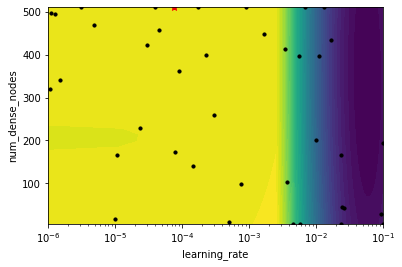

In [ ]:
# WIP
from skopt.plots import plot_objective_2D, plot_objective
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_dense_nodes',
                        levels=50)
# plt.savefig("Lr_numnods.png", dpi=400)

ValueError: ignored

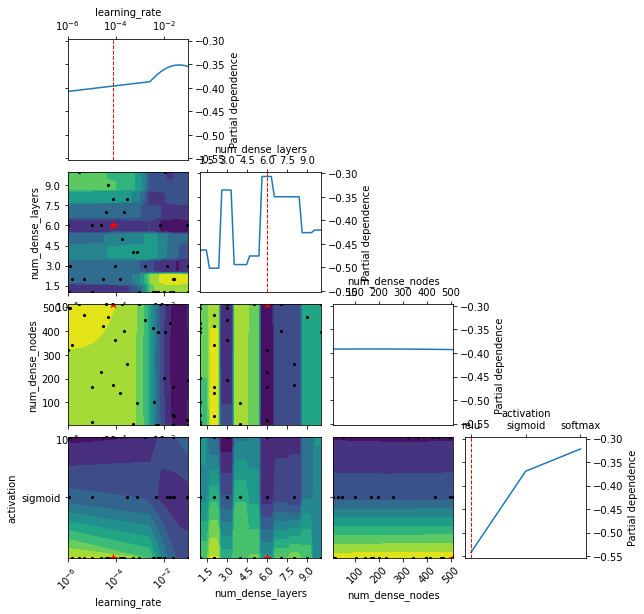

In [ ]:
# WIP
# create a list for plotting
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation' ]
fig, ax = plot_objective(result=search_result, dimensions=dim_names)
plt.savefig("all_dimen.png", dpi=400)

## Compile the best model

In [ ]:
opt_par = search_result.x

# Use the best hyper parameter
learning_rate = opt_par[0]
num_layers = opt_par[1] 
num_nodes = opt_par[2] 
activation = opt_par[3]

model = Sequential()
model.add(InputLayer(input_shape=16))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dropout(0.2))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dropout(0.2))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dense(5, activation='softmax', kernel_initializer='random_normal'))

optimizer = Adam(lr=learning_rate)
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['accuracy'])

# Early Stopping is a callback: once the model doesn't improve, stop the training
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(X_train_full,y_train_full, validation_data=(X_test_full,y_test_full),
          callbacks=[monitor],verbose=2,epochs=48, batch_size = 32)

y_pred = model.predict(X_test_full)

In [ ]:
print(classification_report(np.argmax(np.array(y_test_full), axis = 1), np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       394
           1       0.58      0.74      0.65       394
           2       0.76      0.73      0.75       393
           3       0.88      0.68      0.77       405
           4       0.81      0.71      0.76       414

    accuracy                           0.72      2000
   macro avg       0.74      0.72      0.73      2000
weighted avg       0.74      0.72      0.73      2000

